##まとめ
* RNNはループする経路があり、それによって隠れ状態を内部に記憶することができる
* RNNのループ経路を展開することで、複数のRNNレイヤがつながったネットワークと解釈することができ、通常の誤差逆伝搬法によって学習することができる(=BPTT)
* 長い時系列データを学習する場合は、適当長さでデータのまとまりを作り（これをブロックという）、ブロック単位でBPTTによる学習を行う（=Truncated BPTT）
* Truncated BPTTでは逆伝搬のつながりのみ切断する
* Truncated BPTTでは順伝搬のつながりは維持するため、データはシーケンシャルに与える必要がある
* 言語モデルは単語の並びを確率として解釈する
* RNNレイヤを利用した条件付き言語モデルは、（理論的には）それまで登場した単語の情報を記憶することができる

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


##確率と言語モデル


###word2vecを確率の視点から眺める
CBOWにおいて、コンテキスト$w_{t-1}$と$w_{t+1}$が与えられたとき、ターゲットが$w_t$となる確率は、  

$$
P(w_t|w_{t-1},w_{t+1})
$$  

左側２つの単語をコンテキストとして考えた場合は、  

$$
P(w_t|w_{t-2},w_{t-1})
$$  

その場合の損失関数は、交差エントロピー誤差を適用して、  

$$
L=-\log{P(w_t|w_{t-2},w_{t-1})}
$$

###言語モデル
* 言語モデルは、単語の並びに対して確率を与える
* 単語の並びに対して、それがどれだけ自然な単語の並びなのか、を確率で評価する

$w_1,...,w_m$という順序で単語が出現する確率は同時確率$P(w_1,...,w_m)$で表せるが、この同時確率は事後確率を使って以下のように表せる  

$$
\begin{eqnarray}
P(w_1,...,w_m) &=& P(w_m|w_1,...,w_{m-1})P(w_{m-1}|w_1,...,w_{m-2})...P(w_3|w_1,w_2)P(w_2|w_1)P(w_1)\\&=& \prod_{t=1}^m P(w_t|w_1,...,w_{t-1})
\end{eqnarray}
$$

###CBOWモデルを言語モデルに？
CBOWモデルを無理やり言語モデルに適用するには、コンテキストのサイズをある値に限定する必要がある  
コンテキストのサイズを左側の２つに限定した場合、以下のように近似できる  

$$
P(w_1,...,w_m)=\prod_{t=1}^m P(w_t|w_1,...,w_{t-1})\approx\prod_{t=1}^m P(w_t|w_{t-2},w_{t-1})
$$  
* マルコフ性（または「マルコフモデル」、「マルコフ連鎖」）  
    未来の状態が現在の状態だけに依存して決まること  
* N階マルコフ連鎖  
    ある事象の確率がその直前のN個の事象だけに依存するとき、これを「N階マルコフ連鎖」という  
    （直前の２単語だけに依存して次の単語が決まるモデルは「２階マルコフ連鎖」と呼ぶことができる）  

CBOWモデルではコンテキストのサイズを限定する必要があるため、サイズ外の単語の情報は無視される  
CBOWモデルの中間層では単語ベクトルの和が求められるため、コンテキストの単語の並び方は無視される  
和ではなく連結することで単語の順番を保持できるが、コンテキストのサイズに比例して重みパラメータが増えるため、それは避けたい  
→リカレントニューラルネットワーク（RNN）で解決

##RNNとは

###循環するニューラルネットワーク
* RNNレイヤはループする（閉じた）経路を持つ
* 時刻$t$に入力${\rm x_t}$を入力したときの出力${\rm h_t}$はコピーされ、次の時刻$t+1$のレイヤへと入力される

###ループの展開
各時刻のRNNレイヤはそのレイヤへの入力と一つ前のRNNレイヤからの出力を受け取り、その２つの情報を元にその時刻の出力が計算される(RNNレイヤには$\rm x$に対する重み$\rm W_x$と、$\rm h$に対する重み$\rm W_h$の２種類の重みがある)  

$$
{\rm h}_t=\tanh({\rm h}_{t-1}{\rm W_h}+{\rm x}_t{\rm W_x}+{\rm b})
$$

* tanh関数（ハイパボリックタンジェント）  
tanh関数の出力は、-1から１までの値をとる（シグモイド関数は0から1まで）  

$$
\begin{eqnarray}
{\rm f}(x)&=&\tanh(x)=\dfrac{{\rm e}^x-{\rm e}^{-x}}{{\rm e}^x+{\rm e}^{-x}}\\
{\rm f'}(x)&=&1-{\rm f}(x)^2
\end{eqnarray}
$$


###Backpropagation Trough Time（BPTT）
時間方向に展開した誤差逆伝搬法

###Truncated BPTT
* ネットワークのつながりを適当な長さで断ち切り、小さなネットワークを複数作る
* 切り取ったネットワークそれぞれに対して、誤差逆伝播法を行う
* 断ち切るのは逆伝搬のつながりだけ(順伝搬の流れは途切れることなく伝搬する)
* 1000個の時系列データを扱うとき、RNNレイヤを展開すると横方向に1000個のレイヤが並んだネットワークになる
* ネットワークがあまりにも長いと計算量やメモリの使用量が問題になる.さらに勾配消失が発生する
* Truncated BPTTによってRNNを学習させるときは、データをシーケンシャル（順番）に与える必要がある
    (1000個の時系列データを2つのバッチに分け、Truncated BPTTでネットワークを10個ずつのブロックに断ち切った場合、
     最初のブロックの１つ目のバッチには0から9までのデータ、２つ目のバッチには500から509までのデータを与える.
     ２つ目のブロックの1つ目のバッチには10から19までのデータ、２つ目のバッチには510から519までのデータを与える)

##RNNの実装

###RNNレイヤの実装
行列の形状チェック(バイアスは省略)
$$
{\rm {h}_{t-1}}{\rm {W_h}}+{\rm {x}_{t}{\rm {W_x}}}={\rm {h_t}}\\
(N \times H)(H \times H)+(N \times D)(D \times H)=(N \times H)\\
\begin　{eqnarray}
N&:&バッチサイズ\\
H&:&隠れ状態ベクトルの要素数\\
D&:&入力ベクトルの次元数（単語の分散表現の次元数）
\end{eqnarray}
$$

In [108]:
class RNN:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None

    def forward(self,x,h_prev):
        Wx,Wh,b=self.params
        t=np.dot(h_prev,Wh)+np.dot(x,Wx)+b
        h_next=np.tanh(t)
        self.cache=(x,h_prev,h_next)

        return h_next

    def backward(self,dh_next):
        Wx,Wh,b=self.params
        x,h_prev,h_next=self.cache
        dt=dh_next*(1.-h_next**2)
        db=np.sum(dt,axis=0)    #repeatノードは集約（N×H→H）
        dWh=np.dot(h_prev.T,dt) #逆伝搬してきた方(dt)はいじらないで行列の形状が正しくなるように掛ける方を転置する
        dh_prev=np.dot(dt,Wh.T)
        dWx=np.dot(x.T,dt)
        dx=np.dot(dt,Wx.T)

        self.grads[0][...]=dWx
        self.grads[1][...]=dWh
        self.grads[2][...]=db

        return dx,dh_prev

In [84]:
import numpy as np

x=np.random.randn(2,5)
print('x',x)
print('\nx.shape\n',x.shape)
N,D=x.shape
H=3
h_prev=np.random.randn(N,H)

Wx=0.01*np.random.randn(D,H)
Wh=0.01*np.random.randn(H,H)
b=np.zeros(H)

print('\nh_prev\n',h_prev)
print('\nWx\n',Wx)
print('\nWh\n',Wh)
print('\nb\n',b)

network=RNN(Wx,Wh,b)

#forward
h_next=network.forward(x,h_prev)
print('\nh_next\n',h_next)

#backward
dh_next=np.ones((N,H))
print('\ndh_next\n',dh_next)

dx,dh_prev=network.backward(dh_next)
dWx=network.grads[0]
dWh=network.grads[1]
db=network.grads[2]

print('\ndx\n',dx)
print('\ndh_prev\n',dh_prev)
print('\ndWx\n',dWx)
print('\ndWh\n',dWh)
print('\ndb\n',db)


x [[ 0.03989551 -1.33753659  2.77781523 -0.36335789 -0.39782286]
 [-0.34410591  0.64948128 -1.1256755   0.08680319  0.74699912]]

x.shape
 (2, 5)

h_prev
 [[ 1.14163931  0.99142255  1.00784055]
 [-0.07737676  0.89871819 -0.82135852]]

Wx
 [[ 0.00304896 -0.0082288   0.00773326]
 [ 0.00775807 -0.02690801  0.00638309]
 [ 0.01074696  0.0029286  -0.00733836]
 [ 0.01072262  0.00848788  0.01613718]
 [ 0.00710483 -0.00360007  0.0026387 ]]

Wh
 [[-0.0033952  -0.00416211  0.00647666]
 [ 0.00465863 -0.0018586   0.01456905]
 [-0.00063948 -0.00380815  0.00106478]]

b
 [0. 0. 0.]

h_next
 [[0.01297348 0.03171302 0.        ]
 [0.00310477 0.         0.02483487]]

dh_next
 [[1. 1. 1.]
 [1. 1. 1.]]

dx
 [[ 0.00255342 -0.01276685  0.0063372   0.03534768  0.00614345]
 [ 0.00255342 -0.01276685  0.0063372   0.03534768  0.00614345]]

dh_prev
 [[-0.00108065  0.01736908 -0.00338285]
 [-0.00108065  0.01736908 -0.00338285]]

dWx
 [[-0.30421039 -0.30421039 -0.30421039]
 [-0.68805531 -0.68805531 -0.68805531]
 [ 1.

###Time RNNレイヤの実装
* Time RNNレイヤはT個のRNNレイヤから成る（Tは任意の数）
* Time RNNレイヤはRNNレイヤの隠れ状態hをメンバ変数として保持し、次のブロックへと値を引き渡す
* 隠れ状態hの引き継ぎを行うかどうかは引数statefulで管理する
* statefulがFalseのときは隠れ状態hをゼロ行列で初期化する（状態を保持しないモードであり「ステートレス」と呼ばれる）

In [99]:
class TimeRNN:
    def __init__(self,Wx,Wh,b,stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers=None    #複数のRNNレイヤを格納するメンバ変数を初期化
        self.h,self.dh=None,None    #hとdhを初期化
        self.stateful=stateful  #hを保持するかどうかを管理する引数をメンバ変数に保持

    def set_state(self,h):
        self.h=h

    def reset_state(self):
        self.h=None

    def forward(self,xs):
        Wx,Wh,b=self.params
        N,T,D=xs.shape  #Tは１ブロックに含まれるRNNレイヤの数（=時系列データの数）
        D,H=Wx.shape

        self.layers=[]  #複数のRNNレイヤを格納するリストを作成
        hs=np.empty((N,T,H),dtype='f')

        if not self.stateful or self.h is None: #statefulがFalseまたはself.hの初回呼び出し時は、self.hをゼロ行列で初期化する
            self.h=np.zeros((N,H),dtype='f')

        for t in range(T):
            layer=RNN(*self.params)
            self.h=layer.forward(xs[:,t,:],self.h)  #xsにおける各バッチのt番目のベクトルをforwardの引数として渡す
            hs[:,t,:]=self.h
            self.layers.append(layer)

        return hs

    def backward(self,dhs):
        Wx,Wh,b=self.params
        N,T,H=dhs.shape
        D,H=Wx.shape
        dxs=np.empty((N,T,D),dtype='f')
        dh=0
        grads=[0,0,0]   #[dWx,dWh,db]

        for t in reversed(range(T)):
            layer=self.layers[t]
            dx,dh=layer.backward(dhs[:,t,:]+dh) #順伝搬の際に分岐（コピー）したhは逆伝搬では合算されて伝搬する
            dxs[:,t,:]=dx

            for i,grad in enumerate(layer.grads):  #各RNN layerの勾配（dWx,dWh,db）同士を足し合わせる
                grads[i]+=grad

        for i,grad in enumerate(grads):
            self.grads[i][...]=grad
        self.dh=dh

        return dxs

In [ ]:
import numpy as np

xs=np.random.randn(2,5,5)
print('xs\n',xs)
print('\nxs.shape\n',xs.shape)
N,T,D=xs.shape
H=3

Wx=0.01*np.random.randn(D,H)
Wh=0.01*np.random.randn(H,H)
b=np.zeros(H)

print('\nWx\n',Wx)
print('\nWh\n',Wh)
print('\nb\n',b)

network=TimeRNN(Wx,Wh,b)

#forward
hs=network.forward(xs)
print('\nhs\n',hs)
print('\nlayers\n',network.layers)

# #backward
dhs=np.ones((N,T,H))
print('\ndhs\n',dhs)
dxs=network.backward(dhs)
print('\ndxs\n',dxs)
dWx,dWh,db=network.grads
print('\ndWx\n',dWx)
print('\ndWh\n',dWh)
print('\ndb\n',db)

xs
 [[[-0.63618211  0.10934455 -1.30850419 -0.8162692   0.59417823]
  [-0.53657741  1.14036832  1.10450334  2.86300854 -0.57297783]
  [ 2.06134055 -0.9410649   1.75069735  1.59021476 -0.18281125]
  [-0.70080835  0.64823805  0.23866598 -1.55460456 -1.79561519]
  [-0.26292543 -0.1222049  -0.44097978 -1.11948802  0.66123873]]

 [[-1.07518563 -1.01852707  0.69082961 -1.55398959 -1.54405437]
  [-0.75994002  1.31608444 -0.73171119 -1.42754758  1.43147073]
  [ 0.48028667 -0.09554531 -0.06117461 -0.0455994   0.75968657]
  [ 1.55907695  0.71341106  0.11403865 -2.17180654  0.55244124]
  [ 0.41954237 -0.60029538 -0.77939816  0.28686443  0.74967301]]]

xs.shape
 (2, 5, 5)

Wx
 [[-0.00960174  0.01181981  0.00405078]
 [ 0.00868766 -0.00685055  0.01390331]
 [-0.01249879  0.00579172 -0.00018765]
 [ 0.00922318 -0.01907987  0.01836455]
 [ 0.00112909 -0.00637679  0.002924  ]]

Wh
 [[ 0.01129489 -0.00034219  0.00012349]
 [ 0.00838234  0.00444101 -0.01072788]
 [-0.00028483  0.00632926  0.01080189]]

b
 [0.

##時系列データを扱うレイヤの実装

###RNNLM(RNN Language Model)の全体図
* Embedding→RNN→Affine→Softmax
* Embeddingレイヤへ単語ID（ラベル表記）が入力され、該当の単語の分散表現（Embeddingレイヤの重みW_in）を得る  
    (単語ID（one-hot表記）と重みW_inとの積は指定した単語ID（ラベル表記）の重みを抜き出すことと等価)
* Embeddingレイヤの出力である単語の分散表現がRNNレイヤへの入力となる

###Timeレイヤの実装
* 時系列データ（ここでは各単語を示す）をまとめて処理するレイヤをTime〇〇レイヤとして実装する
* 時系列データの数の各レイヤをまとめたものがTime〇〇レイヤ  
    (Time〇〇レイヤには時系列データの数の〇〇レイヤが生成される)

####Time Embeddingレイヤ

In [ ]:
class TimeEmbedding:
    def __init__(self,W):
        self.params=[W]
        self.grads=[np.zeros_like(W)]
        self.layers=None
        self.W=W

    def forward(self,xs):
        N,T=xs.shape    #N:バッチサイズ,T:時系列データの数
        V,D=self.W.shape    #V:vocab_size,D:単語の分散表現の次元数
        self.layers=[]
        out=np.empty((N,T,D),dtype='f')
        for t in range(T):
            layer=Embedding(self.W)
            out[:,t,:]=layer.forward(xs[:,t])
            self.layers.append(layer)

        return out

    def backward(self,dout):
        N,T,D=dout.shape
        grad=0
        for t in reversed(range(T)):
            layer=self.layers[t]
            layer.backward(dout[:,t,:])
            grad+=layer.grads[0]    #すべてのRNNレイヤの勾配を加算する
        self.grads[0][...]=grad

        return None   

In [ ]:
from common.config import GPU
from common.np import *
from common.layers import Embedding
from common.util import preprocess

text='You say goodbye and I say Hello.'
corpus,word_to_id,id_to_word=preprocess(text)
print('corpus\n',corpus)
V=len(word_to_id)   #語彙数（vocab_size）
N=4 #バッチ数
T=2 #時系列データ数
xs=np.random.randint(0,V,(N,T))
print('\nxs\n',xs)
D=3   #単語の分散表現の次元数（=hidden_size）
W=0.01*np.random.randn(V,D)
print('\nW\n',W)
layer=TimeEmbedding(W)

#forward
out=layer.forward(xs)
print('\nout\n',out)
print('\nlayers\n',layer.layers)

#backward
dout=np.ones_like(out)
print('\ndout\n',dout)
layer.backward(dout)
print('\ndW\n',layer.grads[0])

corpus
 [0 1 2 3 4 1 5 6]

xs
 [[0 2]
 [0 4]
 [3 5]
 [4 6]]

W
 [[ 0.0053589  -0.00406881 -0.00848264]
 [ 0.0009035   0.00286225  0.00539832]
 [ 0.00178114  0.00359424  0.00223916]
 [-0.00498008 -0.00423294  0.01088062]
 [ 0.00783187 -0.0032963   0.00052709]
 [ 0.01204696  0.00436061  0.00623441]
 [-0.00659795 -0.00813407  0.01806852]]

out
 [[[ 0.0053589  -0.00406881 -0.00848264]
  [ 0.00178114  0.00359424  0.00223916]]

 [[ 0.0053589  -0.00406881 -0.00848264]
  [ 0.00783187 -0.0032963   0.00052709]]

 [[-0.00498008 -0.00423294  0.01088062]
  [ 0.01204696  0.00436061  0.00623441]]

 [[ 0.00783187 -0.0032963   0.00052709]
  [-0.00659795 -0.00813407  0.01806852]]]

layers
 [<common.layers.Embedding object at 0x7fdfb0f3bac8>, <common.layers.Embedding object at 0x7fdfb0f3ba58>]

dout
 [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]

dW
 [[2. 2. 2.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [2. 2. 2.]
 [1. 1. 1.]
 [1. 1. 1.]]


####Time Affineレイヤ

In [ ]:
class Simple_TimeAffine:
    def __init__(self,W,b):
        self.params=[W,b]
        self.grads=[np.zeros_like(W),np.zeros_like(b)]
        self.W=W
        self.b=b
        self.layers=None

    def forward(self,xs):
        N,T,D=xs.shape
        D,M=self.W.shape
        self.layers=[]
        out=np.empty((N,T,M),dtype='f')

        for t in range(T):
            layer=Affine(self.W,self.b)
            out[:,t,:]=layer.forward(xs[:,t,:])
            self.layers.append(layer)

        return out

    def backward(self,dout):
        N,T,M=dout.shape
        dW,db=0,0
        dxs=np.empty((N,T,D),dtype='f')
        for t in reversed(range(T)):
            layer=self.layers[t]
            dxs[:,t,:]=layer.backward(dout[:,t,:])
            dW+=layer.grads[0]
            db+=layer.grads[1]
        
        self.grads[0][...]=dW
        self.grads[1][...]=db

        return dxs

In [ ]:
#Simple_TimeAffineの高速版
class TimeAffine:
    def __init__(self,W,b):
        self.params=[W,b]
        self.grads=[np.zeros_like(W),np.zeros_like(b)]
        self.W=W
        self.b=b
        self.x=None

    def forward(self,x):
        N,T,D=x.shape
        D,M=self.W.shape
        rx=x.reshape(N*T,-1)
        out=np.dot(rx,self.W)+self.b
        self.x=x

        return out.reshape(N,T,-1)

    def backward(self,dout):
        N,T,M=dout.shape
        dout=dout.reshape(N*T,-1)
        rx=self.x.reshape(N*T,-1)
        db=np.sum(dout,axis=0)
        dW=np.dot(rx.T,dout)
        dx=np.dot(dout,self.W.T)
        dx=dx.reshape(N,T,-1)

        self.grads[0][...]=dW
        self.grads[1][...]=db

        return dx

In [ ]:
from common.config import GPU
from common.np import *
from common.layers import Affine

N,T,D=2,2,5
M=3
xs=np.random.randn(N,T,D)
print('xs\n',xs)
W=0.01*np.random.randn(D,M)
b=np.zeros(M)

print('\nW\n',W)
print('\nb\n',b)

layer1=Simple_TimeAffine(W,b)
layer2=TimeAffine(W,b)

#forward
out1=layer1.forward(xs)
out2=layer2.forward(xs)
print('\nout1\n',out1)
print('\nout2\n',out2)

#backward
dout=np.ones_like(out1)
print('\ndout\n',dout)
dxs1=layer1.backward(dout)
dxs2=layer2.backward(dout)
print('\ndxs1\n',dxs1)
print('\ndxs2\n',dxs2)
dW1=layer1.grads[0]
dW2=layer2.grads[0]
print('\ndW1\n',dW1)
print('\ndW2\n',dW2)
db1=layer1.grads[1]
db2=layer2.grads[1]
print('\ndb1\n',db1)
print('\ndb2\n',db2)

xs
 [[[-1.51866811 -0.19499086  1.0405191  -0.08156836  0.82008436]
  [-0.68449064 -1.20016951  1.00249497  0.68873807  0.1383732 ]]

 [[ 1.73155296  0.58475799 -0.60211299 -0.31836246  1.11074358]
  [ 0.94870972 -0.54283355  1.48037978  0.75495965 -0.87620754]]]

W
 [[-0.01231775  0.00633112 -0.00113149]
 [-0.02379629  0.0131346  -0.01511444]
 [ 0.00564761 -0.00633733 -0.01516478]
 [-0.0079003   0.00128443  0.01505691]
 [ 0.00672265 -0.00333327 -0.00664547]]

b
 [0. 0. 0.]

out1
 [[[ 0.03538062 -0.02160845 -0.01779173]
  [ 0.03814166 -0.02602709  0.01316248]]

 [[-0.0286621   0.01834771 -0.01384158]
  [-0.00226278 -0.00661483  0.00187172]]]

out2
 [[[ 0.03538063 -0.02160845 -0.01779173]
  [ 0.03814166 -0.02602709  0.01316248]]

 [[-0.0286621   0.01834771 -0.01384158]
  [-0.00226278 -0.00661483  0.00187172]]]

dout
 [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]

dxs1
 [[[-0.00711811 -0.02577613 -0.01585451  0.00844105 -0.00325609]
  [-0.00711811 -0.02577613 -0.01585451  0.008

####Time Softmax With Lossレイヤ
* 損失は各時系列データから個別に計算され、その合計を時系列データ数Tで割ることで平均を取った値になる
* 各時系列に対して損失を求め、それを合計した時系列における損失の合計をさらに各バッチで合計し、(時系列データ数＊バッチ数)で割ることで、各バッチおよび時系列に関して平均を取った値を損失としている

In [ ]:
class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params,self.grads=[],[]
        self.cache=None

    def forward(self,xs,ts):
        N,T,V=xs.shape
        layers=[]
        loss=0
        
        for t in range(T):
            layer=SoftmaxWithLoss()
            loss+=layer.forward(xs[:,t,:],ts[:,t])  #損失の合計を計算
            layers.append(layer)
        loss/=T #時系列データの平均を取る(バッチの平均はSoftmaxWithLossレイヤで行われている)
        self.cache=(layers,xs)

        return loss

    def backward(self,dout=1):
        layers,xs=self.cache
        N,T,V=xs.shape
        dxs=np.empty((N,T,V),dtype='f')
        dout*=1/T

        for t in range(T):
            layer=layers[t]
            dxs[:,t,:]=layer.backward(dout)

        return dxs

In [ ]:
#Simple_TimeSoftmaxWithLossの高速版
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params,self.grads=[],[]
        self.ignor_label=-1
        self.cache=None

    def forward(self,xs,ts):
        N,T,V=xs.shape

        if ts.ndim==3:  #one-hotの場合、ラベル表記に変換する
            ts=ts.argmax(axis=2)

        mask=(ts!=self.ignor_label) #正解ラベルがignor_labelと等しくないときTrue

        #バッチ分と時系列分をまとめる
        xs=xs.reshape(N*T,-1)
        ts=ts.reshape(N*T)
        mask=mask.reshape(N*T)

        ys=softmax(xs)
        ls=np.log(ys[np.arange(N*T),ts])    #ysの正解ラベルに該当するスコアの対数を取る
        ls*=mask    #ignor_labelに該当するデータは損失を0にする
        loss=-np.sum(ls)    #損失の合計を計算
        loss/=mask.sum()  #maskのTrueの数(N*Tの内のignor_label以外のデータ数)で割り、平均を取る
        self.cache=(ts,ys,mask,(N,T,V))

        return loss

    def backward(self,dout):
        ts,ys,mask,(N,T,V)=self.cache
        dx=ys
        dx[np.arange(N*T),ts]-=1  #softmaxWithLossの逆伝搬はy-t,tは正解ラベル(=1)
        dx*=dout
        dx/=mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする
        dx = dx.reshape((N, T, V))

        return dx

In [ ]:
from common.config import GPU
from common.np import *
from common.layers import SoftmaxWithLoss
from common.functions import softmax

N,T,V=2,3,5
xs=np.random.randn(N,T,V)
print('xs\n',xs)
ts=np.random.randint(0,V,(N,T))
print('\nts\n',ts)

layer1=Simple_TimeSoftmaxWithLoss()
layer2=TimeSoftmaxWithLoss()

#forward
loss1=layer1.forward(xs,ts)
loss2=layer2.forward(xs,ts)
print('\nloss1\n',loss1)
print('\nloss2\n',loss2)

#backward
dout=1
print('\ndout\n',dout)
dxs1=layer1.backward(dout)
dxs2=layer2.backward(dout)
print('\ndxs1\n',dxs1)
print('\ndxs2\n',dxs2)

xs
 [[[-2.08602089 -0.094807    1.37386671  1.27351202 -1.24890955]
  [-0.32100937 -0.95114924  1.63696657  0.08440811 -1.019871  ]
  [-1.79221156  0.59913923 -0.74133737  0.10283507  1.63726444]]

 [[-0.75334104  1.15184103  0.32636526  0.15766756  0.93976184]
  [-0.43855666  0.71078725 -0.76266217  0.25050379 -1.54605386]
  [-0.86804302  0.38980687 -1.99782963 -0.6591897  -0.24521999]]]

ts
 [[2 3 4]
 [4 3 0]]

loss1
 1.3127503308789004

loss2
 1.3127507639176783

dout
 1

dxs1
 [[[ 0.00234006  0.01713958 -0.09222141  0.06733697  0.0054048 ]
  [ 0.01570169  0.00836142  0.11124603 -0.14311525  0.00780611]
  [ 0.00318664  0.03482436  0.00911426  0.02120025 -0.06832552]]

 [[ 0.00896655  0.06026089  0.02639587  0.02229829 -0.1179216 ]
  [ 0.02314325  0.07304291  0.0167366  -0.12056894  0.00764618]
  [-0.14566903  0.07386655  0.00678438  0.02587464  0.03914345]]]

dxs2
 [[[ 0.00234006  0.01713958 -0.09222141  0.06733697  0.0054048 ]
  [ 0.01570169  0.00836142  0.11124603 -0.14311525  0.0

##RNNLMの学習と評価

###RNNLMの実装
* Time Embedding → Time RNN → Time Affine → Time SoftmaxWithLoss

In [109]:
class SimpleRnnlm:
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn

        #重みの初期化
        embed_W=(rn(V,D)/100).astype('f')
        rnn_Wx=(rn(D,H)/np.sqrt(D)).astype('f') #Xavierの初期値
        # rnn_Wx=rn(D,H).astype('f')*np.sqrt(2/D) #Heの初期値
        rnn_Wh=(rn(H,H)/np.sqrt(H)).astype('f') #Xavierの初期値
        # rnn_Wh=rn(H,H).astype('f')*np.sqrt(2/H) #Heの初期値
        rnn_b=np.zeros(H).astype('f')
        affine_W=(rn(H,V)/np.sqrt(H)).astype('f')   #Xavierの初期値
        # affine_W=rn(H,V).astype('f')*np.sqrt(2/H)   #Heの初期値
        affine_b=np.zeros(V).astype('f')

        #レイヤの生成
        self.layers=[TimeEmbedding(embed_W),
                     TimeRNN(rnn_Wx,rnn_Wh,rnn_b,stateful=True),
                     TimeAffine(affine_W,affine_b)]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.rnn_layer=self.layers[1]

        #パラメータの格納
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def forward(self,xs,ts):
        for layer in self.layers:
            xs=layer.forward(xs)
        loss=self.loss_layer.forward(xs,ts)
        return loss

    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [ ]:
from common.config import GPU
from common.np import *
from common.layers import Embedding
from common.util import preprocess

text='You say goodbye and I say Hello.'
corpus,word_to_id,id_to_word=preprocess(text)
print('corpus\n',corpus)
V=len(word_to_id)   #語彙数（vocab_size）
D=3 #単語の分散表現の次元数(wordvec_size)
H=5 #RNNの隠れ状態ベクトルの要素数(hidden_size)
N=4 #バッチ数
T=2 #時系列データ数
xs=np.random.randint(0,V,(N,T))
print('\nxs\n',xs)
ts=np.random.randint(0,V,(N,T))
print('\nts\n',ts)

network=SimpleRnnlm(V,D,H)
print('\nembed_W\n',network.params[0])
print('\nrnn_Wx\n',network.params[1])
print('\nrnn_Wh\n',network.params[2])
print('\nrnn_b\n',network.params[3])
print('\naffine_W\n',network.params[4])
print('\naffine_b\n',network.params[5])

#forward
loss=network.forward(xs,ts)
print('\nloss\n',loss)

#backward
dout=1
print('\ndout\n',dout)
network.backward(dout)
print('\nembed_dW\n',network.grads[0])
print('\nrnn_dWx\n',network.grads[1])
print('\nrnn_dWh\n',network.grads[2])
print('\nrnn_db\n',network.grads[3])
print('\naffine_dW\n',network.grads[4])
print('\naffine_db\n',network.grads[5])

corpus
 [0 1 2 3 4 1 5 6]

xs
 [[1 3]
 [3 3]
 [2 6]
 [5 1]]

ts
 [[2 2]
 [5 1]
 [2 0]
 [5 0]]

embed_W
 [[ 0.00310057 -0.00844028  0.02484088]
 [-0.00628202  0.00099597  0.00490091]
 [ 0.00596226 -0.01374394  0.0025489 ]
 [-0.00697657  0.01079278 -0.02313261]
 [ 0.0009852   0.01616624  0.01016055]
 [ 0.01645883 -0.00040422 -0.01518514]
 [ 0.00541164 -0.01458596  0.00597092]]

rnn_Wx
 [[-0.8274789  -0.47252423  0.82563287  0.50500035  0.6020962 ]
 [ 0.2726653   0.21490891 -0.05997231  0.5129342   0.39015675]
 [-0.20823732  0.62016517  0.584389   -0.24629113 -0.57740253]]

rnn_Wh
 [[-0.37151268 -0.4741759   0.13377102  0.78317213  0.15683983]
 [ 0.26014015  0.5402256  -0.02610968 -0.07476007 -0.13132998]
 [ 0.42741707 -0.5278082   0.3569692   0.48413485  0.01771144]
 [-0.22338991 -0.04342097  0.3617978  -0.00443354  0.27900517]
 [ 0.1084639  -0.20848233 -0.05072331  1.0705028  -0.13242473]]

rnn_b
 [0. 0. 0. 0. 0.]

affine_W
 [[ 0.47538662 -1.2527825  -0.44768235  0.37886006  0.36203918 

###言語モデルの評価
* 言語モデルの予測性能の良さを評価する指標として、パープレキシティ(perplexity)がよく用いられる
* パープレキシティは簡単に言うと確率の逆数  
    (You say...という単語の並びがあり、モデルにYouを入力したときにsayの確率として0.8が出力された場合(sayが正解の場合)、パープレキシティは1/0.8=1.25となる)
* パープレキシティが小さいほど予測精度が高いといえる
* パープレキシティの値は、分岐数(次に出現しうる単語の候補の数)と解釈できる  
    (予測精度が高いモデルほど分岐数が絞り込めている)
* 入力データが複数の場合のパープレキシティはモデルの損失を用いて下記のように計算される  

$$
L=-\dfrac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk}\\
\rm {preplexity} = e^L
$$



###RNNLMの学習コード

In [110]:
from common.config import GPU
from common.np import *
from dataset import ptb
from common.optimizer import SGD
from common.layers import *
from common.util import preprocess

#ハイパーパラメータの設定
batch_size=10   #バッチサイズ N
wordvec_size=100    #単語の分散表現の次元数 D
hidden_size=100 #隠れ状態ベクトルの要素数 H
time_size=5 #Trancated BPTTの展開する時間サイズ T
lr=0.1 #学習率
max_epoch=100   #最大エポック

#学習データの読み込み
corpus,word_to_id,id_to_word=ptb.load_data('train')
corpus_size=1000
corpus=corpus[:corpus_size]
# print(corpus)
# text="Minecraft is a 3D sandbox game that has no specific goals to accomplish, allowing players a large amount of freedom in choosing how to play the game.However, there is an achievement system,known as 'advancements' in the Java Edition of the game.Gameplay is in the first-person perspective by default, but players have the option for third-person perspective. The game world is composed of rough 3D objects—mainly cubes and fluids, and commonly called 'blocks'—representing various materials, such as dirt, stone, ores, tree trunks, water, and lava. The core gameplay revolves around picking up and placing these objects. These blocks are arranged in a 3D grid, while players can move freely around the world. Players can 'mine' blocks and then place them elsewhere, enabling them to build things.[23] Many commentators have described the game's physics system as unrealistic.[24] The game also contains a material known as redstone, which can be used to make primitive mechanical devices, electrical circuits, and logic gates, allowing for the construction of many complex systems.The default player skin, Steve, stands on a cliffside overlooking a village in a forest. In the distance, there is a small mountain range. The sun is setting to the right, making the sky turn pink and blue.An example of Minecraft's procedurally-generated terrain, including a village and the default skin SteveThe game world is virtually infinite and procedurally generated as players explore it, using a map seed that is obtained from the system clock at the time of world creation (or manually specified by the player).[26][27][28] There are limits on vertical movement, but Minecraft allows an infinitely large game world to be generated on the horizontal plane. Due to technical problems when extremely distant locations are reached, however, there is a barrier preventing players from traversing to locations beyond 30,000,000 blocks from the center.[i] The game achieves this by splitting the world data into smaller sections called 'chunks' that are only created or loaded when players are nearby.[26] The world is divided into biomes ranging from deserts to jungles to snowfields;[29][30] the terrain includes plains, mountains, forests, caves, and various lava/water bodies.[28] The in-game time system follows a day and night cycle, and one full cycle lasts 20 real-time minutes.When starting a new world, players must choose one of five game modes, as well as one of four difficulties, ranging from peaceful to hard. Increasing the difficulty of the game causes the player to take more damage from mobs, as well as having other difficulty-specific effects. For example, the peaceful difficulty prevents hostile mobs from spawning, and the hard difficulty allows players to starve to death if their hunger bar is depleted.[31][32] Once selected, the difficulty can be changed, but the game mode is locked and can only be changed with cheats."
# corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=int(max(corpus)+1)   #語彙数はコーパスの単語IDの最大値＋１個

xs=corpus[:-1]  #入力はコーパスの最初の単語から最後の単語の一つ前の単語まで
ts=corpus[1:]   #正解ラベルはコーパスの２番目の単語から最後の単語まで
data_size=len(xs)
print('corpus size: %d, vocab size: %d'%(corpus_size,vocab_size))

max_iters=data_size//(batch_size*time_size) #データをすべて見るために必要な繰り返し回数
time_idx=0
total_loss=0    #損失の合計（損失の移動平均計算用）
loss_count=0    #損失を加算した回数（損失の移動平均計算用）
ppl_list=[] #計算したパープレキシティを格納するリスト

#モデルの生成
model=SimpleRnnlm(vocab_size,wordvec_size,hidden_size)
optimizer=SGD(lr)

#ミニバッチの各サンプルの読み込み開始位置を計算
jump=(corpus_size-1)//batch_size
offsets=[i*jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        #ミニバッチの取得
        batch_x=np.empty((batch_size,time_size),dtype='i')
        batch_t=np.empty((batch_size,time_size),dtype='i')
        for t in range(time_size):
            for i,offset in enumerate(offsets):
                #読み込む位置がコーパスのサイズを超えた場合に最初に戻るように、コーパスサイズで割った余りをインデックスにする
                batch_x[i,t]=xs[(offset+time_idx)%data_size]
                batch_t[i,t]=ts[(offset+time_idx)%data_size]
            time_idx+=1

        # print('\nbatch_x\n',batch_x)
        # print('\nbatch_t\n',batch_t)
        #勾配を求め、パラメータを更新
        loss=model.forward(batch_x,batch_t)
        model.backward()
        optimizer.update(model.params,model.grads)
        total_loss+=loss
        loss_count+=1

    #エポックごとにパープレキシティの評価
    # print(loss_count)
    ppl=np.exp(total_loss/loss_count)
    print('| epoch %d | perplexity %.2f'%(epoch+1,ppl))
    ppl_list.append(float(ppl))
    total_loss,loss_count=0,0

corpus size: 1000, vocab size: 418
| epoch 1 | perplexity 407.04
| epoch 2 | perplexity 294.20
| epoch 3 | perplexity 231.31
| epoch 4 | perplexity 218.22
| epoch 5 | perplexity 207.44
| epoch 6 | perplexity 204.06
| epoch 7 | perplexity 199.36
| epoch 8 | perplexity 197.96
| epoch 9 | perplexity 192.31
| epoch 10 | perplexity 193.93
| epoch 11 | perplexity 188.78
| epoch 12 | perplexity 192.77
| epoch 13 | perplexity 190.75
| epoch 14 | perplexity 191.65
| epoch 15 | perplexity 190.51
| epoch 16 | perplexity 187.14
| epoch 17 | perplexity 185.61
| epoch 18 | perplexity 182.24
| epoch 19 | perplexity 183.11
| epoch 20 | perplexity 184.92
| epoch 21 | perplexity 182.05
| epoch 22 | perplexity 178.41
| epoch 23 | perplexity 176.06
| epoch 24 | perplexity 176.79
| epoch 25 | perplexity 174.76
| epoch 26 | perplexity 175.10
| epoch 27 | perplexity 170.64
| epoch 28 | perplexity 168.55
| epoch 29 | perplexity 167.64
| epoch 30 | perplexity 160.89
| epoch 31 | perplexity 161.67
| epoch 32 | 

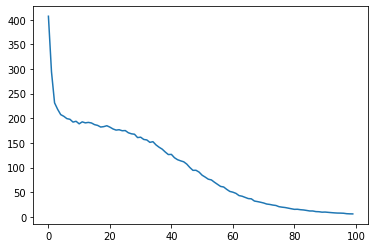

In [111]:
import matplotlib.pyplot as plt

plt.plot(np.arange(max_epoch),ppl_list)
plt.show()

In [112]:
from common.util import *

querys=['deaths','workers','more','researchers']
print(vocab_size)

# print(word_to_id)
keys=list(word_to_id.keys())
vals=list(word_to_id.values())

word_to_id_2={}
id_to_word_2={}
for i in range(vocab_size):
    word_to_id_2[keys[i]]=vals[i]
    id_to_word_2[vals[i]]=keys[i]
print(word_to_id_2)
print(id_to_word_2)
word_vecs=model.params[4].T

for query in querys:
    most_similar(query,word_to_id_2,id_to_word_2,word_vecs,top=5)

418
{'aer': 0, 'banknote': 1, 'berlitz': 2, 'calloway': 3, 'centrust': 4, 'cluett': 5, 'fromstein': 6, 'gitano': 7, 'guterman': 8, 'hydro-quebec': 9, 'ipo': 10, 'kia': 11, 'memotec': 12, 'mlx': 13, 'nahb': 14, 'punts': 15, 'rake': 16, 'regatta': 17, 'rubens': 18, 'sim': 19, 'snack-food': 20, 'ssangyong': 21, 'swapo': 22, 'wachter': 23, '<eos>': 24, 'pierre': 25, '<unk>': 26, 'N': 27, 'years': 28, 'old': 29, 'will': 30, 'join': 31, 'the': 32, 'board': 33, 'as': 34, 'a': 35, 'nonexecutive': 36, 'director': 37, 'nov.': 38, 'mr.': 39, 'is': 40, 'chairman': 41, 'of': 42, 'n.v.': 43, 'dutch': 44, 'publishing': 45, 'group': 46, 'rudolph': 47, 'and': 48, 'former': 49, 'consolidated': 50, 'gold': 51, 'fields': 52, 'plc': 53, 'was': 54, 'named': 55, 'this': 56, 'british': 57, 'industrial': 58, 'conglomerate': 59, 'form': 60, 'asbestos': 61, 'once': 62, 'used': 63, 'to': 64, 'make': 65, 'kent': 66, 'cigarette': 67, 'filters': 68, 'has': 69, 'caused': 70, 'high': 71, 'percentage': 72, 'cancer': 73

###RNNLMのTrainerクラス

In [ ]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads